# 模型选择、欠拟合和过拟合

In [9]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [10]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [11]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.2930],
         [ 1.5662]]),
 tensor([[ 1.0000e+00, -2.9300e-01,  4.2924e-02, -4.1923e-03,  3.0708e-04,
          -1.7995e-05,  8.7876e-07, -3.6782e-08,  1.3472e-09, -4.3857e-11,
           1.2850e-12, -3.4228e-14,  8.3574e-16, -1.8836e-17,  3.9422e-19,
          -7.7004e-21,  1.4101e-22, -2.4304e-24,  3.9561e-26, -6.1008e-28],
         [ 1.0000e+00,  1.5662e+00,  1.2265e+00,  6.4034e-01,  2.5073e-01,
           7.8539e-02,  2.0502e-02,  4.5871e-03,  8.9806e-04,  1.5628e-04,
           2.4478e-05,  3.4852e-06,  4.5488e-07,  5.4804e-08,  6.1311e-09,
           6.4017e-10,  6.2666e-11,  5.7735e-12,  5.0236e-13,  4.1411e-14]]),
 tensor([4.5054, 6.2602]))

In [12]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [13]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.0275564  1.1918885 -3.390093   5.605367 ]]


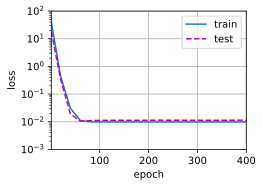

In [14]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[2.3318548 5.8957167]]


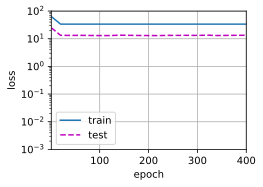

In [21]:
# 从多项式特征中选择前2个维度，即1和x（欠拟合）
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 5.01499033e+00  1.24261999e+00 -3.33453274e+00  5.40551996e+00
  -1.77902237e-01  4.55434740e-01  2.82087892e-01 -5.30816495e-01
   1.14885807e-01 -9.04696435e-02 -1.90082476e-01 -4.06379299e-03
   1.22452125e-01  9.84900817e-02 -2.14709267e-01 -1.63852885e-01
  -4.02748808e-02 -1.54545203e-01 -5.62805608e-02  1.29141569e-01]]


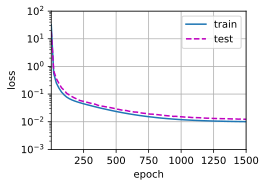

In [22]:
# 从多项式特征中选取所有维度(图像显示的过拟合效果不是很明显)
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)